In [3]:
import time
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout,UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [0]:


tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)



In [0]:
'''
import pickle
with open('../seen_dataset.pickle', 'wb') as f:
    pickle.dump(../seen_dataset,f)
with open('../unseen_dataset.pickle', 'wb') as f:
    pickle.dump(unseen_dataset,f)
with open('../shuffled_dataset.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(shuffled_dataset,f)
'''

import pickle


with open('../seen_dataset.pickle', 'rb') as f:
    seen_dataset = pickle.load(f)
with open('../unseen_dataset.pickle', 'rb') as f:
    unseen_dataset = pickle.load(f)
with open('../shuffled_dataset.pickle', 'rb') as f:
    shuffled_dataset = pickle.load(f)


In [8]:
train_images = [*shuffled_dataset['train_imgs']]
val_images = [*shuffled_dataset['val_imgs']]
csv_data = pd.read_csv('15features.csv')
display(csv_data.head())
display(csv_data.shape)



len(train_images)+len(val_images)


,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(13570, 16)

13794

In [9]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2
5,1316a_num2.png,2,2,1,1,2,2,3,1,1,2,2,2,3,2,2
6,1503c_num2.png,2,1,2,2,2,2,2,1,1,3,2,2,3,2,2
7,0113c_num1.png,2,3,2,2,2,1,2,1,1,1,2,2,2,2,2
8,0221a_num6.png,2,2,2,2,2,1,1,1,1,4,1,2,3,1,2
9,0068a_num4.png,1,1,2,2,2,2,1,1,1,2,2,2,2,2,2


(13570, 16)

In [10]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [11]:
from keras.models import load_model
encoder = load_model('../seen_encoder.h5')


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
encoder.summary()
for layer in encoder.layers:
    layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
__________

In [13]:
dense_layer = encoder.get_layer('latent').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 32, 32, 16)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 8)    1160        max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
max_poolin

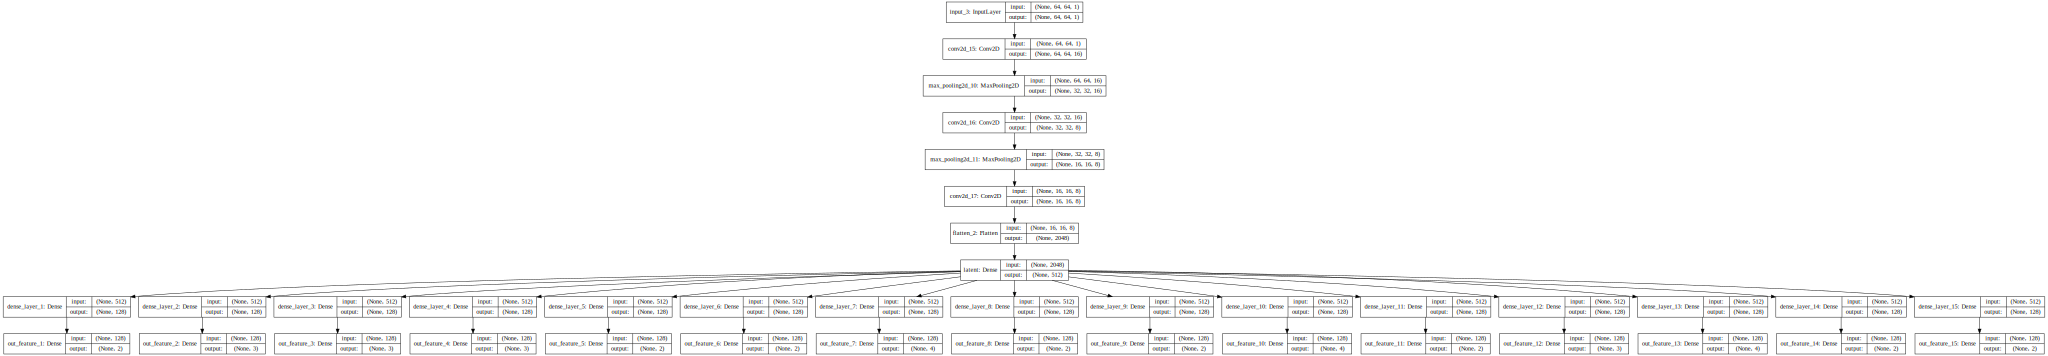

In [14]:
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [15]:


feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths



[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [0]:
def datagen(batch_size,dataset,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:

        
        writer_index = np.random.randint(0,len(list_of_writers))

        imagename = list_of_writers[writer_index]

        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
            continue
        features = features[0][1:]-1



        loaded_image = dataset[imagename]
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)

        counter+=1
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]

In [0]:
batch_size = 64

tg = datagen(batch_size,shuffled_dataset['train_imgs'],vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,shuffled_dataset['val_imgs'],vshift=(-10,10), list_of_writers=val_images)

In [18]:


# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])


(64, 64, 64, 1)
1
2
1
2
2
2
1
1
1
2
2
3
2
1
1


In [19]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

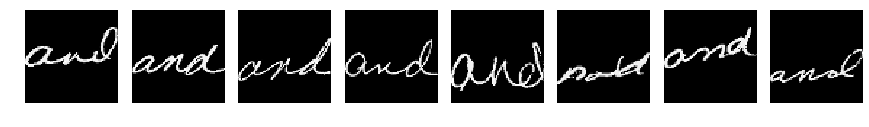

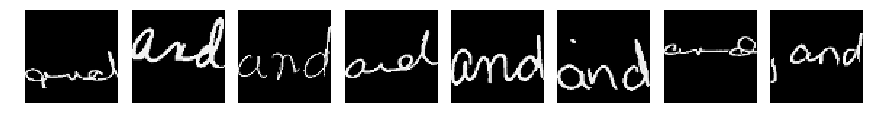

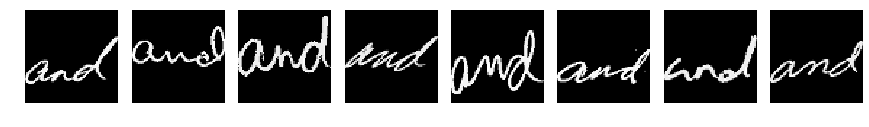

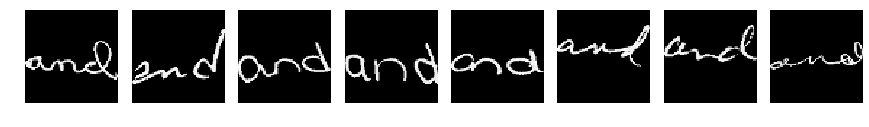

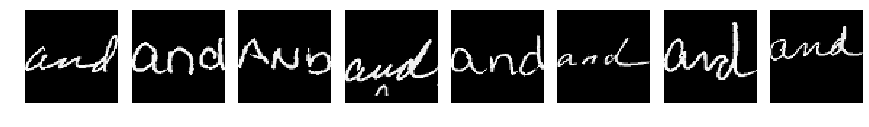

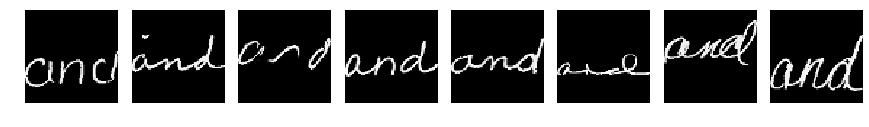

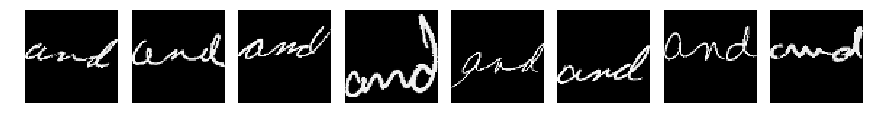

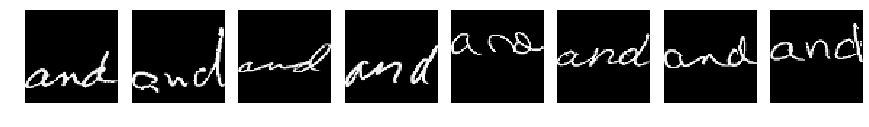

In [20]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [0]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0

In [0]:
!mkdir weights

In [0]:
mc = ModelCheckpoint(filepath='weights/15-Multitask-FrozenEncoder-shuffled_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [24]:
EPOCHS = 5000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 32, 32, 16)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 8)    1160        max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
max_poolin

In [25]:
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5000

Epoch 00001: val_loss improved from inf to 57.56665, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 2/5000

Epoch 00002: val_loss improved from 57.56665 to 48.28188, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 3/5000

Epoch 00003: val_loss improved from 48.28188 to 39.21314, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 4/5000

Epoch 00004: val_loss improved from 39.21314 to 36.23153, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 5/5000

Epoch 00005: val_loss did not improve from 36.23153
Epoch 6/5000

Epoch 00006: val_loss improved from 36.23153 to 33.65859, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 7/5000

Epoch 00007: val_loss improved from 33.65859 to 31.08916, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 8/5000

Epoch 00008: val_loss did not improve from 31.089

20.38819694519043


,loss,out_feature_10_acc,out_feature_10_loss,out_feature_11_acc,out_feature_11_loss,out_feature_12_acc,out_feature_12_loss,out_feature_13_acc,out_feature_13_loss,out_feature_14_acc,...,val_out_feature_5_acc,val_out_feature_5_loss,val_out_feature_6_acc,val_out_feature_6_loss,val_out_feature_7_acc,val_out_feature_7_loss,val_out_feature_8_acc,val_out_feature_8_loss,val_out_feature_9_acc,val_out_feature_9_loss


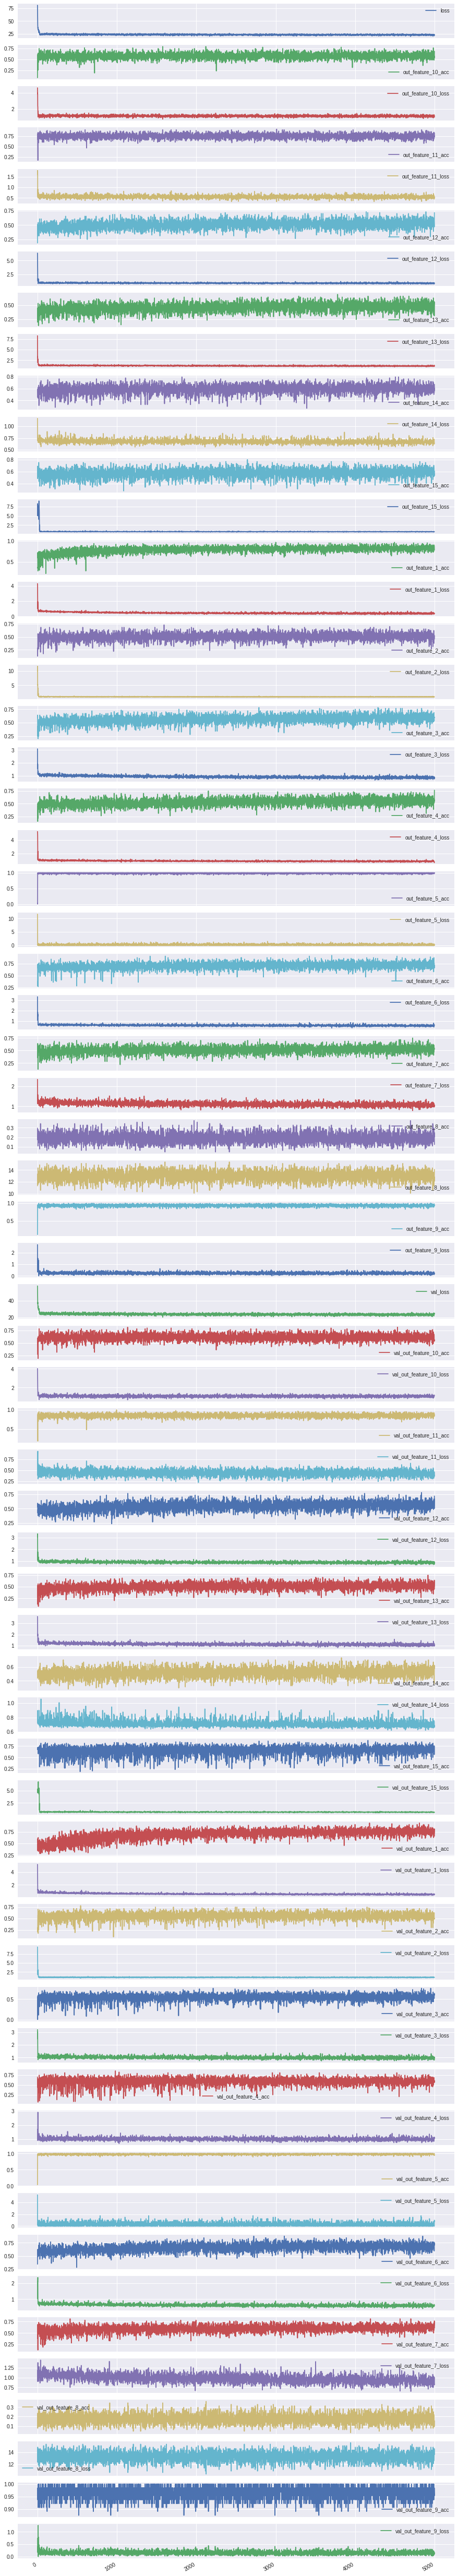

In [26]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<6.31]

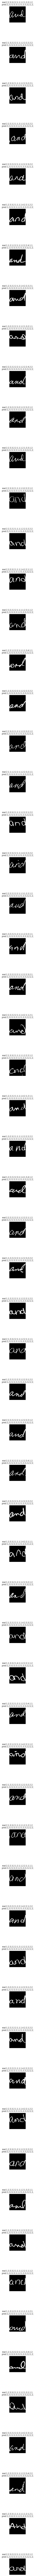

In [27]:
human_features.load_weights('weights/15-Multitask-FrozenEncoder-shuffled_v1.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
    
    real=''
    for f in range(15):
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
    pred=''
    for prob in f_probs:
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)

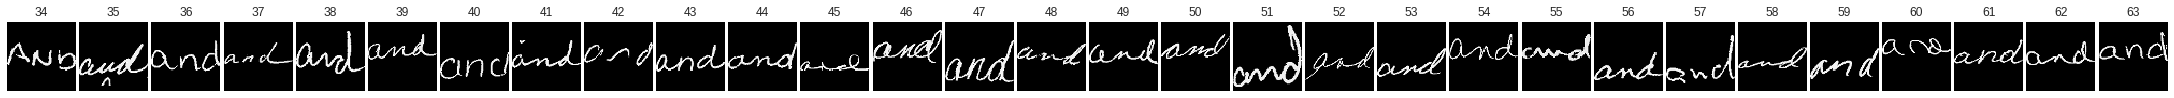

In [28]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

In [29]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64

In [0]:
def accuracy(pred,obs):
    total = (pred == obs).astype('int64')
    total = total.values.tolist()
    return sum(total)/len(pred)

def train_similarity_model(dataset,feat_model):
    
    
    combined_model = BayesianModel([('is_lowercase1','is_lowercase_sim'),
                                    ('is_lowercase2','is_lowercase_sim'),
                                    ('is_continuous1','is_continuous_sim'),
                                    ('is_continuous2','is_continuous_sim'),              
                                    ('dimension1','dimension_sim'),
                                    ('dimension2','dimension_sim'),
                                    ('letter_spacing1','letter_spacing_sim'),
                                    ('letter_spacing2','letter_spacing_sim'),
                                    ('size1','size_sim'),
                                    ('size2','size_sim'),              
                                    ('constancy1','constancy_sim'),
                                    ('constancy2','constancy_sim'),
                                    ('word_formation1','word_formation_sim'),
                                    ('word_formation2','word_formation_sim'),
                                    ('formation_n1','formation_n_sim'),
                                    ('formation_n2','formation_n_sim'),
                                    ('entry_stroke_a1','entry_stroke_a_sim'),
                                    ('entry_stroke_a2', 'entry_stroke_a_sim'),
                                    ('exit_stroke_d1','exit_stroke_d_sim'),
                                    ('exit_stroke_d2', 'exit_stroke_d_sim'),
                                    ('staff_of_a1','staff_of_a_sim'),
                                    ('staff_of_a2', 'staff_of_a_sim'),
                                    ('staff_of_d1','staff_of_d_sim'),
                                    ('staff_of_d2', 'staff_of_d_sim'),
                                    ('slantness1','slantness_sim'),
                                    ('slantness2', 'slantness_sim'),
                                    ('tilt1','tilt_sim'),
                                    ('tilt2', 'tilt_sim'),
                                    ('pen_pressure1','pen_pressure_sim'),
                                    ('pen_pressure2', 'pen_pressure_sim'),
                                    
                                    ('is_lowercase_sim','is_continuous_sim'),
                                    ('dimension_sim','size_sim'),
                                    ('letter_spacing_sim','size_sim'),
                                    ('size_sim','constancy_sim'),
                                    ('constancy_sim','word_formation_sim'),
                                    ('word_formation_sim','formation_n_sim'),
                                    ('entry_stroke_a_sim','exit_stroke_d_sim'),
                                    ('staff_of_a_sim','staff_of_d_sim'),
                                    ('slantness_sim','tilt_sim'),
                                    
                                    ('is_continuous_sim','label'),
                                    ('formation_n_sim','label'),
                                    ('exit_stroke_d_sim','label'),
                                    ('staff_of_d_sim','label'),
                                    ('pen_pressure_sim','label'),
                                    ('tilt_sim','label')
                                   ])
    # nx.draw(combined_model, **options)
    
    cpd_is_lowercase1 = TabularCPD('is_lowercase1',2,[[0.5],
                                                    [0.5]],
                                                    evidence=[], evidence_card=[])
    cpd_is_lowercase2 = TabularCPD('is_lowercase2',2,[[0.5],
                                                    [0.5]],
                                                    evidence=[], evidence_card=[])
    cpd_is_continuous1 = TabularCPD('is_continuous1',2,[[0.5],
                                                    [0.5]],
                                                    evidence=[], evidence_card=[])
    cpd_is_continuous2 = TabularCPD('is_continuous2',2,[[0.5],
                                                    [0.5]],
                                                    evidence=[], evidence_card=[])
    cpd_dimension1 = TabularCPD('dimension1',3,[[0.33],
                                        [0.34],[0.33]],
                                                    evidence=[], evidence_card=[])
    cpd_dimension2 = TabularCPD('dimension2',3,[[0.33],
                                        [0.34],[0.33]],
                                                    evidence=[], evidence_card=[])
    cpd_letter_spacing1 = TabularCPD('letter_spacing1',3,[[0.33],
                                        [0.34],[0.33]],
                                        evidence=[], evidence_card=[])
    cpd_letter_spacing2 = TabularCPD('letter_spacing2',3,[[0.33],
                                        [0.34],[0.33]],
                                        evidence=[], evidence_card=[])
    cpd_size1 = TabularCPD('size1',3,[[0.33],
                                        [0.34],[0.33]],
                                        evidence=[], evidence_card=[])
    cpd_size2 = TabularCPD('size2',3,[[0.33],
                                        [0.34],[0.33]],
                                        evidence=[], evidence_card=[])
    cpd_constancy1 = TabularCPD('constancy1',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_constancy2 = TabularCPD('constancy2',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_word_formation1 = TabularCPD('word_formation1',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_word_formation2 = TabularCPD('word_formation2',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_formation_n1 = TabularCPD('formation_n1',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_formation_n2 = TabularCPD('formation_n2',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_entry_stroke_a1 = TabularCPD('entry_stroke_a1',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_entry_stroke_a2 = TabularCPD('entry_stroke_a2',2,[[0.5],
                                        [0.5]],
                                        evidence=[], evidence_card=[])
    cpd_exit_stroke_d1 = TabularCPD('exit_stroke_d1',4,[[0.3],
                                                    [0.5],[0.1],
                                                    [0.1]],
                                        evidence=[], evidence_card=[])
    cpd_exit_stroke_d2 = TabularCPD('exit_stroke_d2',4,[[0.3],
                                                    [0.5],[0.1],
                                                    [0.1]],
                                        evidence=[], evidence_card=[])
    cpd_staff_of_a1 = TabularCPD('staff_of_a1',4,[[0.2],[0.6],
                                            [0.05],[0.15]],
                                        evidence=[], evidence_card=[])
    cpd_staff_of_a2 = TabularCPD('staff_of_a2',4,[[0.2],[0.6],
                                            [0.05],[0.15]],
                                        evidence=[], evidence_card=[])
    cpd_staff_of_d1 = TabularCPD('staff_of_d1',2,[[0.1],
                                        [0.9]],
                                        evidence=[], evidence_card=[])
    cpd_staff_of_d2 = TabularCPD('staff_of_d2',2,[[0.1],
                                        [0.9]],
                                        evidence=[], evidence_card=[])
    cpd_slantness1 = TabularCPD('slantness1',4,[[0.55],[0.30],
                                            [0.10],[0.05]],
                                        evidence=[], evidence_card=[])
    cpd_slantness2 = TabularCPD('slantness2',4,[[0.55],[0.30],
                                            [0.10],[0.05]],
                                        evidence=[], evidence_card=[])
    cpd_tilt1 = TabularCPD('tilt1',2,[[0.8],[0.2]],
                                        evidence=[], evidence_card=[])
    cpd_tilt2 = TabularCPD('tilt2',2,[[0.8],[0.2]],
                                        evidence=[], evidence_card=[])
    cpd_pen_pressure1 = TabularCPD('pen_pressure1',2,[[0.4],[0.6]],
                                        evidence=[], evidence_card=[])
    cpd_pen_pressure2 = TabularCPD('pen_pressure2',2,[[0.4],[0.6]],
                                        evidence=[], evidence_card=[])
    
    
    
    cpd_is_lowercase_sim = TabularCPD('is_lowercase_sim',2,[[0.1,0.9,0.9,0.1],
                                                                [0.9,0.1,0.1,0.9]],
                                                                evidence=['is_lowercase1','is_lowercase2'], 
                                                                evidence_card=[2,2])
    cpd_is_continuous_sim = TabularCPD('is_continuous_sim',2,[[0.9,0.1,0.9,0.6,0.9,0.6,0.9,0.1],
                                                              [0.1,0.9,0.1,0.4,0.1,0.4,0.1,0.9]],
                                                                evidence=['is_continuous1','is_continuous2','is_lowercase_sim'], 
                                                                evidence_card=[2,2,2])
    cpd_dimension_sim = TabularCPD('dimension_sim',2,[[0.1,0.8,0.9,0.8,0.1,0.8,0.9,0.8,0.1],
                                                      [0.9,0.2,0.1,0.2,0.9,0.2,0.1,0.2,0.9]],
                                                    evidence=['dimension1','dimension2'], evidence_card=[3,3])
    cpd_letter_spacing_sim = TabularCPD('letter_spacing_sim',2,[[0.1,0.8,0.9,0.8,0.1,0.8,0.9,0.8,0.1],
                                                    [0.9,0.2,0.1,0.2,0.9,0.2,0.1,0.2,0.9]],
                                                    evidence=['letter_spacing1','letter_spacing2'], evidence_card=[3,3])
    cpd_size_sim = TabularCPD('size_sim',2,[[0.6,0.3,0.3,0.1,0.8,0.7,0.7,0.3,0.9,0.8,0.7,0.4,0.7,0.6,0.6,0.3,0.6,0.3,0.3,0.1,0.8,0.4,0.4,0.85,0.9,0.8,0.8,0.3,0.8,0.4,0.4,0.85,0.6,0.3,0.3,0.1],
                                            [0.4,0.7,0.7,0.9,0.2,0.3,0.3,0.7,0.1,0.2,0.3,0.6,0.3,0.4,0.4,0.7,0.4,0.7,0.7,0.9,0.2,0.6,0.6,0.15,0.1,0.2,0.2,0.7,0.2,0.6,0.6,0.15,0.4,0.7,0.7,0.9]],
                                            evidence=['size1','size2','dimension_sim','letter_spacing_sim'], evidence_card=[3,3,2,2])
    cpd_constancy_sim = TabularCPD('constancy_sim',2,[[0.9,0.1,0.9,0.6,0.9,0.6,0.7,0.1],
                                            [0.1,0.9,0.1,0.4,0.1,0.4,0.3,0.9]],
                                            evidence=['constancy1','constancy2','size_sim'], evidence_card=[2,2,2])
    cpd_word_formation_sim = TabularCPD('word_formation_sim',2,[[0.9,0.1,0.9,0.7,0.9,0.7,0.9,0.1],
                                            [0.1,0.9,0.1,0.3,0.1,0.3,0.1,0.9]],
                                            evidence=['word_formation1','word_formation2','constancy_sim'], evidence_card=[2,2,2])
    cpd_formation_n_sim = TabularCPD('formation_n_sim',2,[[0.7,0.1,0.9,0.4,0.9,0.4,0.6,0.1],
                                            [0.3,0.9,0.1,0.6,0.1,0.6,0.4,0.9]],
                                            evidence=['formation_n1','formation_n2','word_formation_sim'], evidence_card=[2,2,2])
    cpd_entry_stroke_a_sim = TabularCPD('entry_stroke_a_sim',2,[[0.1,0.9,0.9,0.1],
                                                                [0.9,0.1,0.1,0.9]],
                                            evidence=['entry_stroke_a1','entry_stroke_a2'], evidence_card=[2,2])
    
    cpd_exit_stroke_d_sim = TabularCPD('exit_stroke_d_sim',2,[[0.47, 0.53, 0.79, 0.21, 0.88, 0.12, 0.88, 0.12, 0.42, 0.58, 0.26, 0.74, 0.52, 0.48, 0.42, 0.58, 0.84, 0.16, 0.78, 0.22, 0.36, 0.64, 0.55, 0.45, 0, 1, 0, 1, 0, 1, 0, 1],
                                                              [0.53, 0.47, 0.21, 0.79, 0.12, 0.88, 0.12, 0.88, 0.58, 0.42, 0.74, 0.26, 0.48, 0.52, 0.58, 0.42, 0.16, 0.84, 0.22, 0.78, 0.64, 0.36, 0.45, 0.55, 1, 0, 1, 0, 1, 0, 1, 0]],
                                            evidence=['exit_stroke_d1','exit_stroke_d2','entry_stroke_a_sim'], evidence_card=[4,4,2])
    cpd_staff_of_d_sim = TabularCPD('staff_of_d_sim',2,[[0.9,0.1,0.9,0.7,0.9,0.7,0.9,0.1],
                                            [0.1,0.9,0.1,0.3,0.1,0.3,0.1,0.9]],
                                            evidence=['staff_of_d1','staff_of_d2','staff_of_a_sim'], evidence_card=[2,2,2])
    cpd_tilt_sim = TabularCPD('tilt_sim',2,[[0.9,0.1,0.9,0.7,0.9,0.7,0.9,0.1],
                                            [0.1,0.9,0.1,0.3,0.1,0.3,0.1,0.9]],
                                            evidence=['tilt1','tilt2','slantness_sim'], evidence_card=[2,2,2])
    cpd_pen_pressure_sim = TabularCPD('pen_pressure_sim',2,[[0.1,0.9,0.9,0.1],
                                                           [0.9,0.1,0.1,0.9]],
                                            evidence=['pen_pressure1','pen_pressure2'], evidence_card=[2,2])
    cpd_staff_of_a_sim = TabularCPD('staff_of_a_sim',2,[[0.63, 0.86, 0.87, 0.79, 0.23, 0.13, 0.17, 0.17, 0, 0, 0, 0, 0.60, 0.61, 0.78, 0.39],
                                                  [0.37, 0.14, 0.13, 0.21, 0.77, 0.87, 0.83, 0.83, 1, 1, 1, 1, 0.40, 0.39, 0.22, 0.61]],
                                            evidence=['staff_of_a1','staff_of_a2'], evidence_card=[4,4])
    cpd_slantness_sim = TabularCPD('slantness_sim',2,[[0.63, 0.86, 0.87, 0.79, 0.23, 0.13, 0.17, 0.17, 0, 0, 0, 0, 0.60, 0.61, 0.78, 0.39],
                                                  [0.37, 0.14, 0.13, 0.21, 0.77, 0.87, 0.83, 0.83, 1, 1, 1, 1, 0.40, 0.39, 0.22, 0.61]],
                                            evidence=['slantness1','slantness2'], evidence_card=[4,4])
    rand_prob = list(np.around(np.random.uniform(0.0,1.0,64),2))
    cpd_label = TabularCPD('label',2,[[0.8580167417900838, 0.8580167417900838, 0.6366459627329193, 0.6366459627329193, 0.6366459627329192, 0.6366459627329192, 0.33687705412837876, 0.33687705412837876, 0.8453901800831153, 0.8453901800831153, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.3149100257069408, 0.3149100257069408, 0.8580167417900838, 0.8580167417900838, 0.6366459627329193, 0.6366459627329193, 0.6366459627329192, 0.6366459627329192, 0.33687705412837876, 0.33687705412837876, 0.8453901800831153, 0.8453901800831153, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.3149100257069408, 0.3149100257069408, 0.6850899742930591, 0.6850899742930591, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.15460981991688466, 0.15460981991688466, 0.6631229458716212, 0.6631229458716212, 0.3633540372670807, 0.3633540372670807, 0.36335403726708076, 0.36335403726708076, 0.14198325820991628, 0.14198325820991628, 0.6850899742930591, 0.6850899742930591, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.15460981991688466, 0.15460981991688466, 0.6631229458716212, 0.6631229458716212, 0.3633540372670807, 0.3633540372670807, 0.36335403726708076, 0.36335403726708076, 0.14198325820991628, 0.14198325820991628 ],
                                     [0.14198325820991628, 0.14198325820991628, 0.36335403726708076, 0.36335403726708076, 0.36335403726708076, 0.36335403726708076, 0.6631229458716211, 0.6631229458716211, 0.15460981991688466, 0.15460981991688466, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.6850899742930591, 0.6850899742930591, 0.14198325820991628, 0.14198325820991628, 0.36335403726708076, 0.36335403726708076, 0.36335403726708076, 0.36335403726708076, 0.6631229458716211, 0.6631229458716211, 0.15460981991688466, 0.15460981991688466, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.38679245283018865, 0.6850899742930591, 0.6850899742930591, 0.3149100257069408, 0.3149100257069408, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.8453901800831153, 0.8453901800831153, 0.33687705412837887, 0.33687705412837887, 0.6366459627329193, 0.6366459627329193, 0.6366459627329193, 0.6366459627329193, 0.8580167417900838, 0.8580167417900838, 0.3149100257069408, 0.3149100257069408, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.6132075471698113, 0.8453901800831153, 0.8453901800831153, 0.33687705412837887, 0.33687705412837887, 0.6366459627329193, 0.6366459627329193, 0.6366459627329193, 0.6366459627329193, 0.8580167417900838, 0.8580167417900838 ]],
                           evidence=['is_continuous_sim','exit_stroke_d_sim','formation_n_sim','staff_of_d_sim','tilt_sim','pen_pressure_sim'],
                           evidence_card=[2,2,2,2,2,2])
    
    combined_model.add_cpds(cpd_pen_pressure1,
                            cpd_pen_pressure2,
                            cpd_pen_pressure_sim,
                            cpd_letter_spacing1,
                            cpd_letter_spacing2,
                            cpd_letter_spacing_sim,
                            cpd_size1,
                            cpd_size2,
                            cpd_size_sim,
                            cpd_dimension1,
                            cpd_dimension2,
                            cpd_dimension_sim,
                            cpd_is_lowercase1,
                            cpd_is_lowercase2,
                            cpd_is_lowercase_sim,
                            cpd_is_continuous1,
                            cpd_is_continuous2,
                            cpd_is_continuous_sim,
                            cpd_slantness1,
                            cpd_slantness2,
                            cpd_slantness_sim,
                            cpd_tilt1,
                            cpd_tilt2,
                            cpd_tilt_sim,
                            cpd_entry_stroke_a1,
                            cpd_entry_stroke_a2,
                            cpd_entry_stroke_a_sim,
                            cpd_staff_of_a1,
                            cpd_staff_of_a2,
                            cpd_staff_of_a_sim,
                            cpd_formation_n1,
                            cpd_formation_n2,
                            cpd_formation_n_sim,
                            cpd_staff_of_d1,
                            cpd_staff_of_d2,
                            cpd_staff_of_d_sim,
                            cpd_exit_stroke_d1,
                            cpd_exit_stroke_d2,
                            cpd_exit_stroke_d_sim,
                            cpd_word_formation1,
                            cpd_word_formation2,
                            cpd_word_formation_sim,
                            cpd_constancy1,
                            cpd_constancy2,
                            cpd_constancy_sim,
                            cpd_label
                           )
    runtime = time.time()
    target = dataset['val_target']
    pred_left = np.zeros((len(target),15)).astype(int)
    pred_right = np.zeros((len(target),15)).astype(int)
    for i in range(len(target)):
        prob_l =  feat_model.predict(dataset['val_left'][i].reshape(1,64,64,1))
        prob_r = feat_model.predict(dataset['val_right'][i].reshape(1,64,64,1))
        for j in range(len(prob_l)):
            pred_left[i][j]=np.argmax(prob_l[j])+1
            pred_right[i][j]=np.argmax(prob_r[j])+1

    pred_features = np.concatenate((pred_left,pred_right,target.reshape(len(target),1)),axis=1)

    pred_features =  pd.DataFrame(pred_features)

    pred_features.columns =  ['pen_pressure1','letter_spacing1' ,'size1' ,'dimension1','is_lowercase1','is_continuous1','slantness1','tilt1','entry_stroke_a1','staff_of_a1','formation_n1','staff_of_d1','exit_stroke_d1','word_formation1','constancy1',
                              'pen_pressure2','letter_spacing2' ,'size2' ,'dimension2','is_lowercase2','is_continuous2','slantness2','tilt2','entry_stroke_a2','staff_of_a2','formation_n2','staff_of_d2','exit_stroke_d2','word_formation2','constancy2',
                              'label']

    pred =  combined_model.predict(pred_features.drop(['label'],axis=1)-2)['label']
    runtime = time.time() - runtime
    return combined_model, accuracy(pred,pred_features['label']), runtime

In [0]:
def conv(col):
    tmp = np.empty((len(col),64,64,1))
  
    for i in range(len(col)):
        tmp[i]=col.iloc[i]
    return tmp

def convert(dic):
    dic['val_left'] = conv(dic['val_left']).astype('float32') / 255.
    dic['val_right'] = conv(dic['val_right']).astype('float32') / 255.
    dic['val_target'] = np.array(dic['val_target'])
    return dic

In [0]:

seen_dataset = convert(seen_dataset)

unseen_dataset = convert(unseen_dataset)

shuffled_dataset = convert(shuffled_dataset)


In [0]:
shuffled_epl =  train_similarity_model(shuffled_dataset,human_features)

In [34]:
print("Accuracy %.2f \n Time :%f"%(shuffled_epl[1],shuffled_epl[2]))

Accuracy 0.50 
 Time :929.565544
